In [144]:
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import numpy as np 
import xgboost as xgb
from matplotlib.offsetbox import AnchoredText
import heapq
import math 
from nasspython.nass_api import nass_data
from NdviApi import NDVI
import seaborn as sns

In [145]:
plt.style.use('ggplot')

In [146]:
""" 
Helpful Links:
https://geo.fas.usda.gov/GADAS/index.html#
https://glam1.gsfc.nasa.gov/
https://www.mdpi.com/2072-4292/13/21/4227
https://glam1.gsfc.nasa.gov/api/doc/db/versions#default-db
"""

' \nHelpful Links:\nhttps://geo.fas.usda.gov/GADAS/index.html#\nhttps://glam1.gsfc.nasa.gov/\nhttps://www.mdpi.com/2072-4292/13/21/4227\nhttps://glam1.gsfc.nasa.gov/api/doc/db/versions#default-db\n'

In [147]:

# Generic function to initialize dataframes from USDA Quickstats data
def initialize_df(states, week, start_yr, end_yr, freq, suffix, var):
    temp = pd.DataFrame(nass_data("B3744D45-DFBE-3B88-AFB1-25CBC8E64550", agg_level_desc="STATE", freq_desc=freq, short_desc=var)['data'])
    temp = temp[temp["state_name"].isin(states)]
    if (freq == "WEEKLY"):
        temp = temp[temp["reference_period_desc"].eq(f"WEEK #{week}")]
    elif (freq == "ANNUAL"):
        temp = temp[temp["reference_period_desc"].eq("YEAR")]
    temp = temp[temp["year"].ge(start_yr) & temp["year"].le(end_yr)]
    temp = temp.pivot(index='year', columns='state_name', values="Value")
    temp = temp.add_suffix(suffix)
    temp = temp.replace(",", "", regex=True)
    temp = temp.fillna(0).astype(float)
    return temp 

In [148]:

# NDVI data via https://glam1.gsfc.nasa.gov/
def get_ndvi_data(states, ids, mask, threshold, index):
    acc_ndvi_df = pd.DataFrame(index=index)
    for i in range(len(ids)):
        acc_ndvi = list()
        df = NDVI().get_data(
                            version='v15', 
                            sat='MOD',
                            mask=mask, 
                            shape='ADM',
                            start_yr=2000,
                            end_yr=2023,
                            start_month=1,
                            num_months=12,
                            ids=ids[i],
                            ts_type='cumulative',
                            mcv=0.0
                            )
        count=0
        for j in range(df.shape[0]):
            if (int(df.loc[j, "ORDINAL DATE"][-3:]) == 329):
                acc_ndvi.append(count)
                count=0
            elif (df.loc[j, "SAMPLE VALUE"] >= threshold): 
                count+=df.loc[j, "SAMPLE VALUE"] 
        acc_ndvi_df[states[i] + " NDVI"] = acc_ndvi  
    return acc_ndvi_df

In [149]:

# Drought index data from https://droughtmonitor.unl.edu/About.aspx
def get_drought_data(states, ids, start_yr, end_yr, index):
    drought_data = pd.DataFrame(index=index)
    for i in range (len(ids)):
        if len(str(ids[i])) == 1:
            df = pd.read_json(f"https://usdmdataservices.unl.edu/api/StateStatistics/GetDroughtSeverityStatisticsByArea?aoi=0{ids[i]}&startdate=1/1/{start_yr}&enddate=1/1/{end_yr+1}&statisticsType=1")
        else:
            df = pd.read_json(f"https://usdmdataservices.unl.edu/api/StateStatistics/GetDroughtSeverityStatisticsByArea?aoi={ids[i]}&startdate=1/1/{start_yr}&enddate=1/1/{end_yr+1}&statisticsType=1")
        df = df.loc[:, ["ValidStart", "None", "D0", "D1", "D2", "D3", "D4"]]
        df["ValidStart"] = pd.to_datetime(df["ValidStart"]).dt.to_period('Y')
        df = df.iloc[::-1].set_index("ValidStart", drop=True)
        df = df.replace(",", "", regex=True)
        df = df.fillna(0).astype(float)
        df = df.groupby(lambda x: x.year)[["None", "D0", "D1", "D2", "D3", "D4"]].mean()
        df.index.name = None
        df = df.add_prefix(f"{states[i]} ")
        drought_data = pd.concat([drought_data, df], axis=1)
    return drought_data

In [150]:
"""
Function to initialize data

Pass crop, week to take data from, and array of 1s and 0s indicating which additional variables to include.

Available crops are "CORN", "WHEAT, WINTER" and "SOYBEAN"

Below are the available variables, in order:
1. PCT Excellent at current week
2. PCT Good at current week
3. PCT Change in Excellent (pct @ week - pct @ week - 10)
4. PCT Change in Good (pct @ week - pct @ week - 10)
5. Acres planted/year
6. Acres harvested at current week
7. PCT Mature at current week
8. Drought data

Sample input below
"""


def get_data(crop, week, start_yr=2000, end_yr=2023, var_arr=[]):
    
    if (crop == "CORN"):
        mask = "USDA-NASS-CDL_2018-2023_corn-50pp"
        states = ["WISCONSIN", "SOUTH DAKOTA", "OHIO", "NEBRASKA", "MISSOURI", "MINNESOTA", "KANSAS", "IOWA", "INDIANA", "ILLINOIS"]
        ndvi_ids = [26264, 26237, 26258, 26228, 26253, 26251, 26226, 26246, 26245, 26244]
        drought_ids = [55, 46, 39, 31, 29, 27, 20, 19, 18, 17]
        threshold = 0.58
    elif (crop == "SOYBEANS"):
        mask = "USDA-NASS-CDL_2018-2023_soybean-50pp"
        states = ["SOUTH DAKOTA", "OHIO", "NORTH DAKOTA", "NEBRASKA", "MISSOURI", "MINNESOTA", "IOWA", "INDIANA", "ILLINOIS", "ARKANSAS"]
        ndvi_ids = [26237, 26258, 26236, 26228, 26253, 26251, 26246, 26245, 26244, 26240]
        drought_ids = [46, 39, 38, 31, 29, 27, 19, 18, 17, 5]
        threshold = 0.58
    elif (crop == "WHEAT, WINTER"):
        mask = "USDA-NASS-CDL_2018-2023_winterwheat-50pp"
        states = ["WASHINGTON", "SOUTH DAKOTA", "OKLAHOMA", "NEBRASKA", "MONTANA", "MISSOURI", "KANSAS", "ILLINOIS", "IDAHO", "COLORADO"]
        ndvi_ids = [26234, 26237, 26230, 26228, 26227, 26253, 26226, 26244, 26225, 26224]
        drought_ids = [53, 46, 40, 31, 30, 29, 20, 17, 16, 8]
        threshold = 0.34

    idx = list(range(start_yr, end_yr + 1))
    """
    Get crop mask from: https://glam1.gsfc.nasa.gov/api/doc/db/versions#default-db
    """
    df = get_ndvi_data(states, ndvi_ids, mask=mask, threshold=threshold, index=idx)
    
    if (crop == "CORN"):
        yields = initialize_df(states, None, start_yr, end_yr, "ANNUAL", "", "CORN, GRAIN - YIELD, MEASURED IN BU / ACRE")
    else:
        yields = initialize_df(states, None, start_yr, end_yr, "ANNUAL", "", f"{crop} - YIELD, MEASURED IN BU / ACRE")

    overlay = pd.DataFrame()
    
    additional_vars = {
                    0: f"{crop} - CONDITION, MEASURED IN PCT EXCELLENT",
                    1: f"{crop} - CONDITION, MEASURED IN PCT GOOD",
                    2: f"{crop} - CONDITION, MEASURED IN PCT EXCELLENT",
                    3: f"{crop} - CONDITION, MEASURED IN PCT GOOD",
                    4: "PCT CHNGE EXCELLENT",
                    5: "PCT CHNGE GOOD",
                    6: f"{crop} - ACRES PLANTED",
                    7: f"{crop} - PROGRESS, MEASURED IN PCT HARVESTED",
                    8: f"{crop} - PROGRESS, MEASURED IN PCT MATURE",
                    9: "Drought data" 
    }

    for i in range(8):
        if var_arr[i] == 1:
            if i == 2:
                excellent_24 = initialize_df(states, week - 10, start_yr, end_yr, "WEEKLY", " EXCLNT 10 WK CHNGE", additional_vars[i])
                excellent_34 = initialize_df(states, week, start_yr, end_yr, "WEEKLY", " EXCLNT 10 WK CHNGE", additional_vars[i])
                pct_chnge_excellent = excellent_34 - excellent_24
                overlay = pd.concat([overlay, pct_chnge_excellent], axis=1)
            elif i == 3:
                good_24 = initialize_df(states, week - 10, start_yr, end_yr, "WEEKLY", " GD 10 WK CHNGE", additional_vars[i])
                good_34 = initialize_df(states, week, start_yr, end_yr, "WEEKLY", " GD 10 WK CHNGE", additional_vars[i])
                pct_chnge_good = good_34 - good_24
                overlay = pd.concat([overlay, pct_chnge_good], axis=1)
            elif i == 4:
                planted = initialize_df(states, None, start_yr, end_yr, "ANNUAL", " ACRES PLANTED", additional_vars[6])
                overlay = pd.concat([overlay, planted], axis=1)
            elif i == 5:
                if (crop == "CORN"):
                    harvested = initialize_df(states, week, start_yr, end_yr, "WEEKLY", " ACRES HARVESTED", "CORN, GRAIN - PROGRESS, MEASURED IN PCT HARVESTED")
                else:
                    harvested = initialize_df(states, week, start_yr, end_yr, "WEEKLY", " ACRES HARVESTED", additional_vars[7])
                overlay = pd.concat([overlay, harvested], axis=1)
            elif i == 6:
                maturity = initialize_df(states, week, start_yr, end_yr, "WEEKLY", " PCT MATURE", additional_vars[8])
                overlay = pd.concat([overlay, maturity], axis=1)
            elif i == 7:
                drought_index = get_drought_data(states, drought_ids, 2000, 2023, idx)
                overlay = pd.concat([overlay, drought_index], axis=1)
            elif i == 0:
                temp = initialize_df(states, week, start_yr, end_yr, "WEEKLY", " PCT EXCELLENT", additional_vars[i])
                overlay = pd.concat([overlay, temp], axis=1)   
            elif i == 1:
                temp = initialize_df(states, week, start_yr, end_yr, "WEEKLY", " PCT GOOD", additional_vars[i])
                overlay = pd.concat([overlay, temp], axis=1)

    
    x = pd.concat([df, overlay], axis=1)
    x.fillna(0, inplace=True)
    cols = x.columns
    scaler = MinMaxScaler()
    x = scaler.fit_transform(x)
    x = pd.DataFrame(x, columns=cols)
    
    return yields, x

y, x = get_data("CORN", 34, 2000, 2023, [1, 1, 1, 1, 1, 1, 1, 1])


x.head()


,WISCONSIN NDVI,SOUTH DAKOTA NDVI,OHIO NDVI,NEBRASKA NDVI,MISSOURI NDVI,MINNESOTA NDVI,KANSAS NDVI,IOWA NDVI,INDIANA NDVI,ILLINOIS NDVI,...,INDIANA D1,INDIANA D2,INDIANA D3,INDIANA D4,ILLINOIS None,ILLINOIS D0,ILLINOIS D1,ILLINOIS D2,ILLINOIS D3,ILLINOIS D4
0,0.692242,0.340499,0.621601,0.029884,0.879042,0.442379,0.300894,0.285127,0.375975,0.438817,...,0.829290,0.776953,0.0,0.0,0.246703,0.753297,0.833463,0.390822,0.0,0.0
1,1.000000,0.074472,0.055121,0.376607,0.818707,0.324482,0.416915,0.308956,0.000000,0.000000,...,0.203287,0.087303,0.0,0.0,0.722689,0.277311,0.102602,0.043187,0.0,0.0
2,0.718573,0.249520,0.000000,0.000000,0.545901,0.832714,0.000000,0.626130,0.123245,0.185908,...,0.347411,0.101279,0.0,0.0,0.668020,0.331980,0.160884,0.011395,0.0,0.0
3,0.255946,0.025720,0.548603,0.461761,0.693129,0.000000,0.000000,0.000000,0.185647,0.218308,...,0.296681,0.220742,0.0,0.0,0.392332,0.607668,0.519172,0.318498,0.0,0.0
4,0.490657,0.616507,0.812663,0.388496,0.932448,0.828996,0.604105,0.672966,0.742070,0.706197,...,0.026463,0.000000,0.0,0.0,0.897513,0.102487,0.000008,0.000000,0.0,0.0


In [151]:

# Extra Vegetation Health index (VHI) data for corn (just call the function if you want it). Taken out due to noise

vhi_links = ["https://www.star.nesdis.noaa.gov/smcd/emb/vci/VH/get_TS_admin.php?provinceID=14&country=USA&yearlyTag=Yearly&type=Parea_VHI&TagCropland=MAIZ&year1=1982&year2=2024",
             "https://www.star.nesdis.noaa.gov/smcd/emb/vci/VH/get_TS_admin.php?provinceID=15&country=USA&yearlyTag=Yearly&type=Parea_VHI&TagCropland=MAIZ&year1=1982&year2=2024",
             "https://www.star.nesdis.noaa.gov/smcd/emb/vci/VH/get_TS_admin.php?provinceID=16&country=USA&yearlyTag=Yearly&type=Parea_VHI&TagCropland=MAIZ&year1=1982&year2=2024",
             "https://www.star.nesdis.noaa.gov/smcd/emb/vci/VH/get_TS_admin.php?provinceID=17&country=USA&yearlyTag=Yearly&type=Parea_VCI&TagCropland=MAIZ&year1=1982&year2=2024",
             "https://www.star.nesdis.noaa.gov/smcd/emb/vci/VH/get_TS_admin.php?provinceID=24&country=USA&yearlyTag=Yearly&type=Parea_VHI&TagCropland=MAIZ&year1=1982&year2=2024",
             "https://www.star.nesdis.noaa.gov/smcd/emb/vci/VH/get_TS_admin.php?provinceID=26&country=USA&yearlyTag=Yearly&type=Parea_VHI&TagCropland=MAIZ&year1=1982&year2=2024",
             "https://www.star.nesdis.noaa.gov/smcd/emb/vci/VH/get_TS_admin.php?provinceID=28&country=USA&yearlyTag=Yearly&type=Parea_VHI&TagCropland=MAIZ&year1=1982&year2=2024",
             "https://www.star.nesdis.noaa.gov/smcd/emb/vci/VH/get_TS_admin.php?provinceID=36&country=USA&yearlyTag=Yearly&type=Parea_VHI&TagCropland=MAIZ&year1=1982&year2=2024",
             "https://www.star.nesdis.noaa.gov/smcd/emb/vci/VH/get_TS_admin.php?provinceID=42&country=USA&yearlyTag=Yearly&type=Parea_VHI&TagCropland=MAIZ&year1=1982&year2=2024",
             "https://www.star.nesdis.noaa.gov/smcd/emb/vci/VH/get_TS_admin.php?provinceID=50&country=USA&yearlyTag=Yearly&type=Parea_VHI&TagCropland=MAIZ&year1=1982&year2=2024"]

def get_vhi_data(links):
    for i in range(len(links)):
        global x 
        vhi = pd.read_csv(links[i], skiprows=3)
        vhi = vhi.iloc[list(range(17, 41)), :]
        vhi.reset_index(inplace=True)
        vhi.set_index(vhi.columns[1], drop=True, inplace=True)
        vhi.drop(columns="index", inplace=True)
        vhi.index.name = None
        VHI_bins = list(range(0, 105, 5))
        vhi.drop(columns="Unnamed: 22", inplace=True)
        vhi.columns = VHI_bins
        vhi = vhi.add_prefix(y.columns[i] + " VHI Bin")
        vhi.index = x.index 
        x = pd.concat([x, vhi], axis=1)

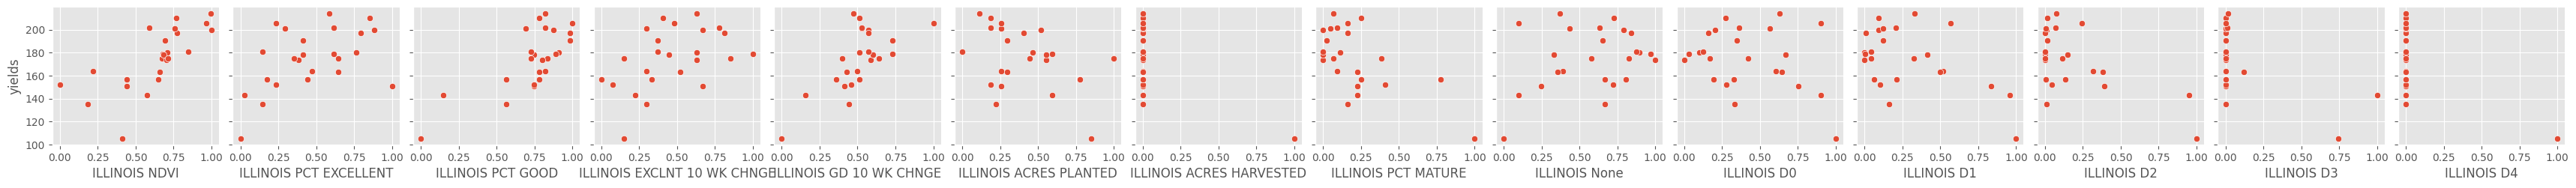

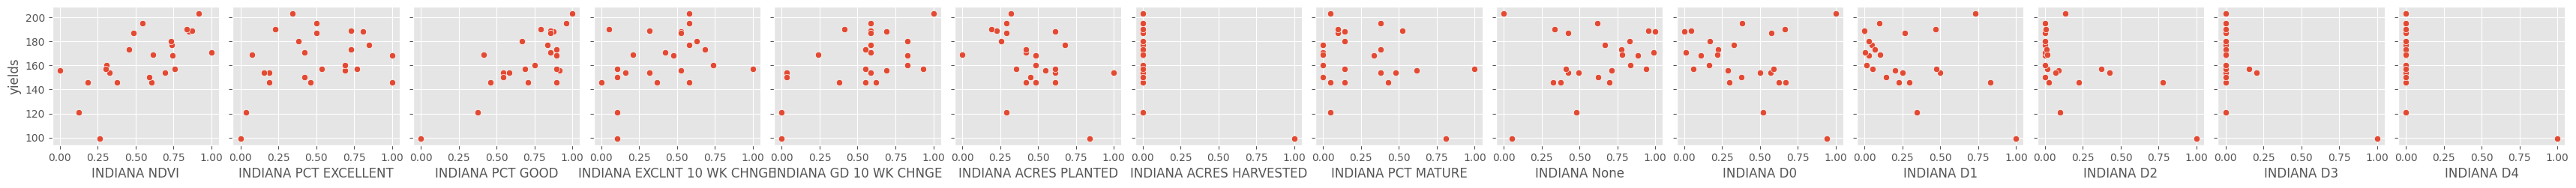

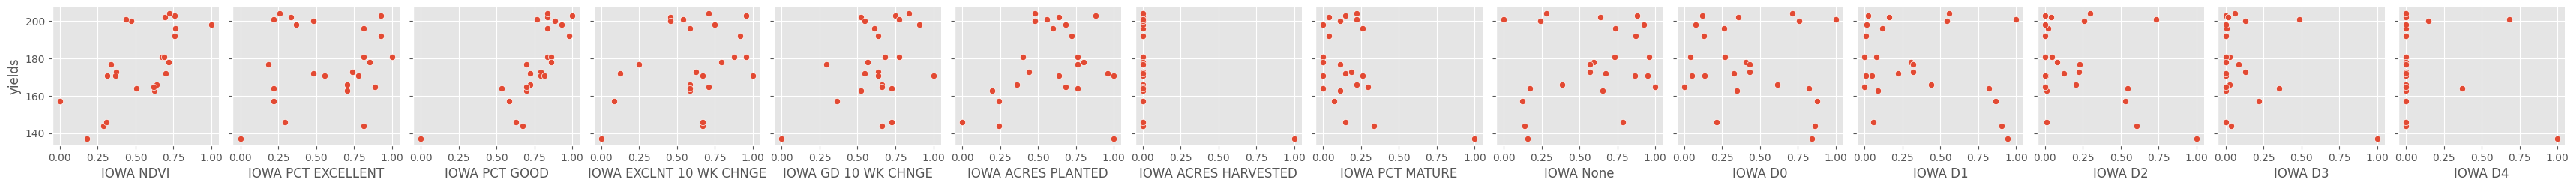

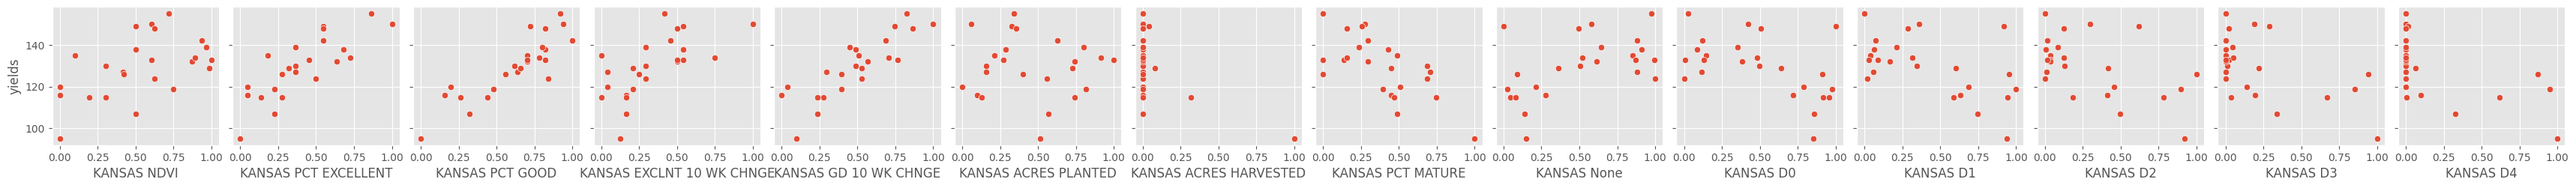

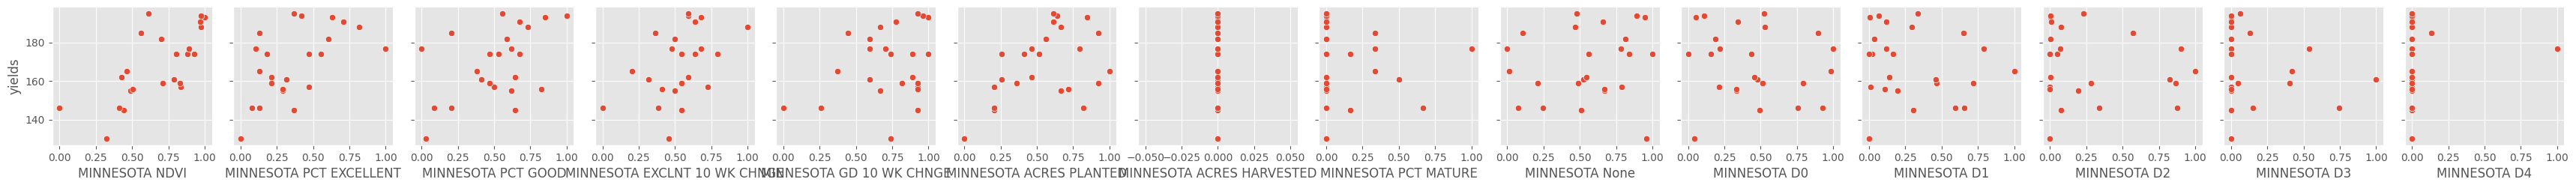

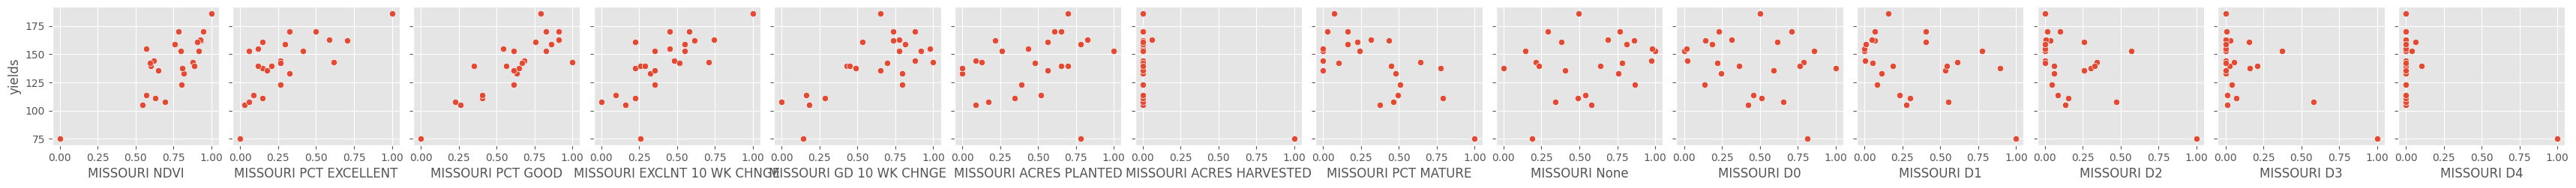

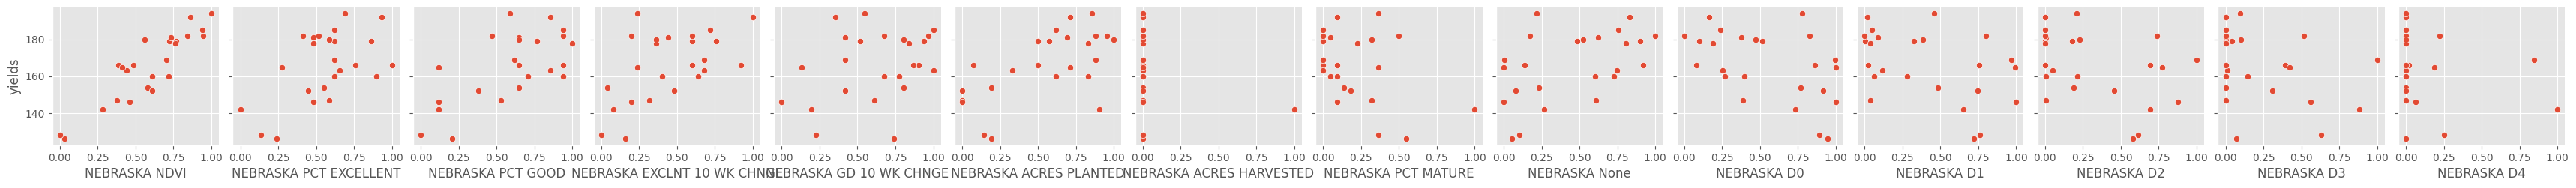

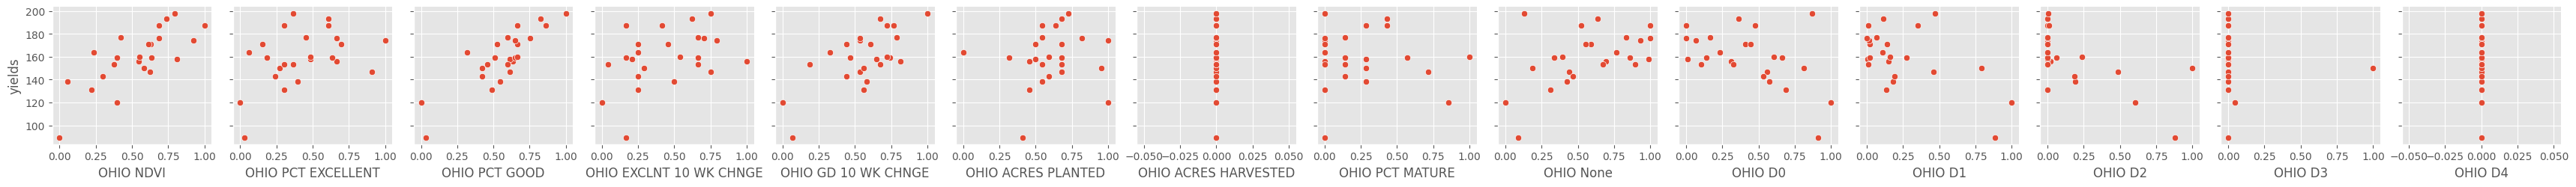

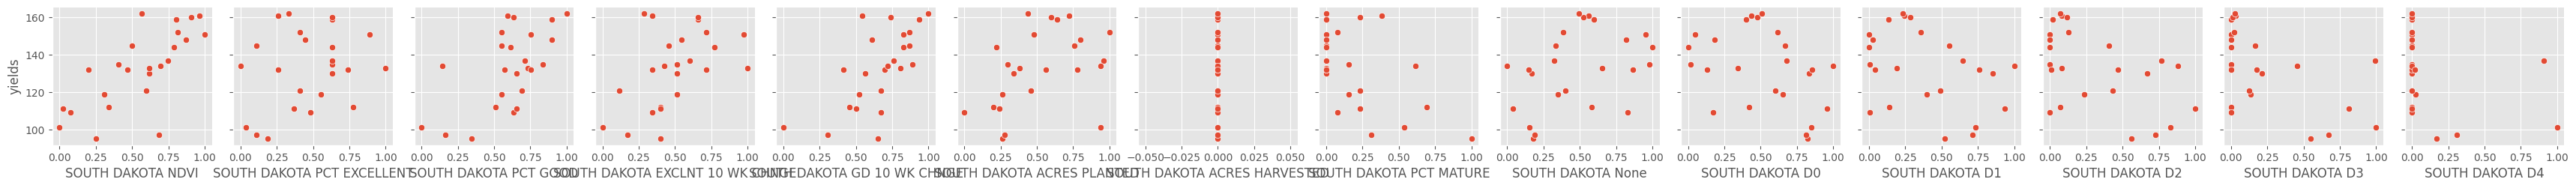

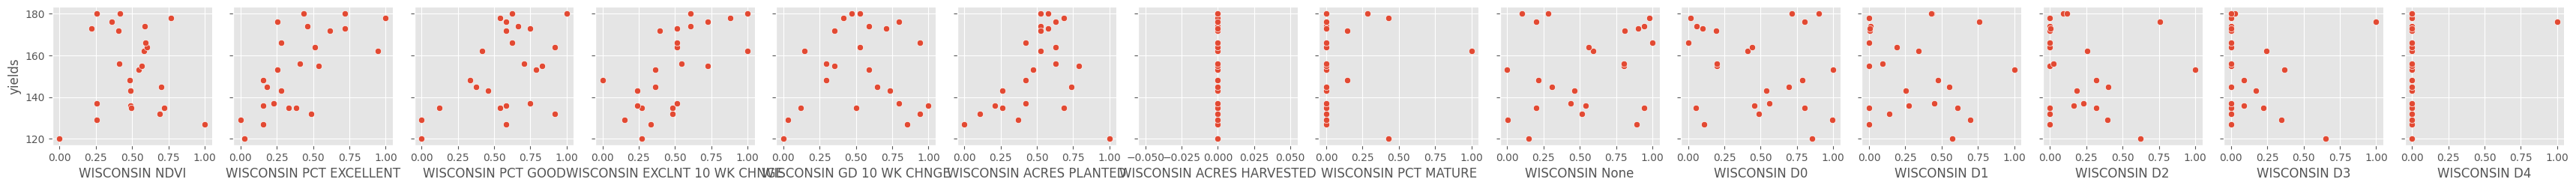

In [152]:
for state in y.columns:
    state_data = x.filter(regex=state)
    temp = pd.DataFrame(y[state], columns=[state])
    temp.reset_index(drop=True, inplace=True)
    g = sns.pairplot(state_data.assign(yields=temp[state]), y_vars=['yields'][:], x_vars=state_data.columns)
    sns.despine();

C:\Users\Oliver Li\AppData\Local\Temp\ipykernel_4588\765019012.py:5: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr = x.filter(regex=state).apply(lambda x: spearmanr(x, y[state])[0])
C:\Users\Oliver Li\AppData\Local\Temp\ipykernel_4588\765019012.py:5: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr = x.filter(regex=state).apply(lambda x: spearmanr(x, y[state])[0])
C:\Users\Oliver Li\AppData\Local\Temp\ipykernel_4588\765019012.py:5: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr = x.filter(regex=state).apply(lambda x: spearmanr(x, y[state])[0])
C:\Users\Oliver Li\AppData\Local\Temp\ipykernel_4588\765019012.py:5: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr = x.filter(regex=state).apply(lambda x: spearmanr(x, y[state])[0])


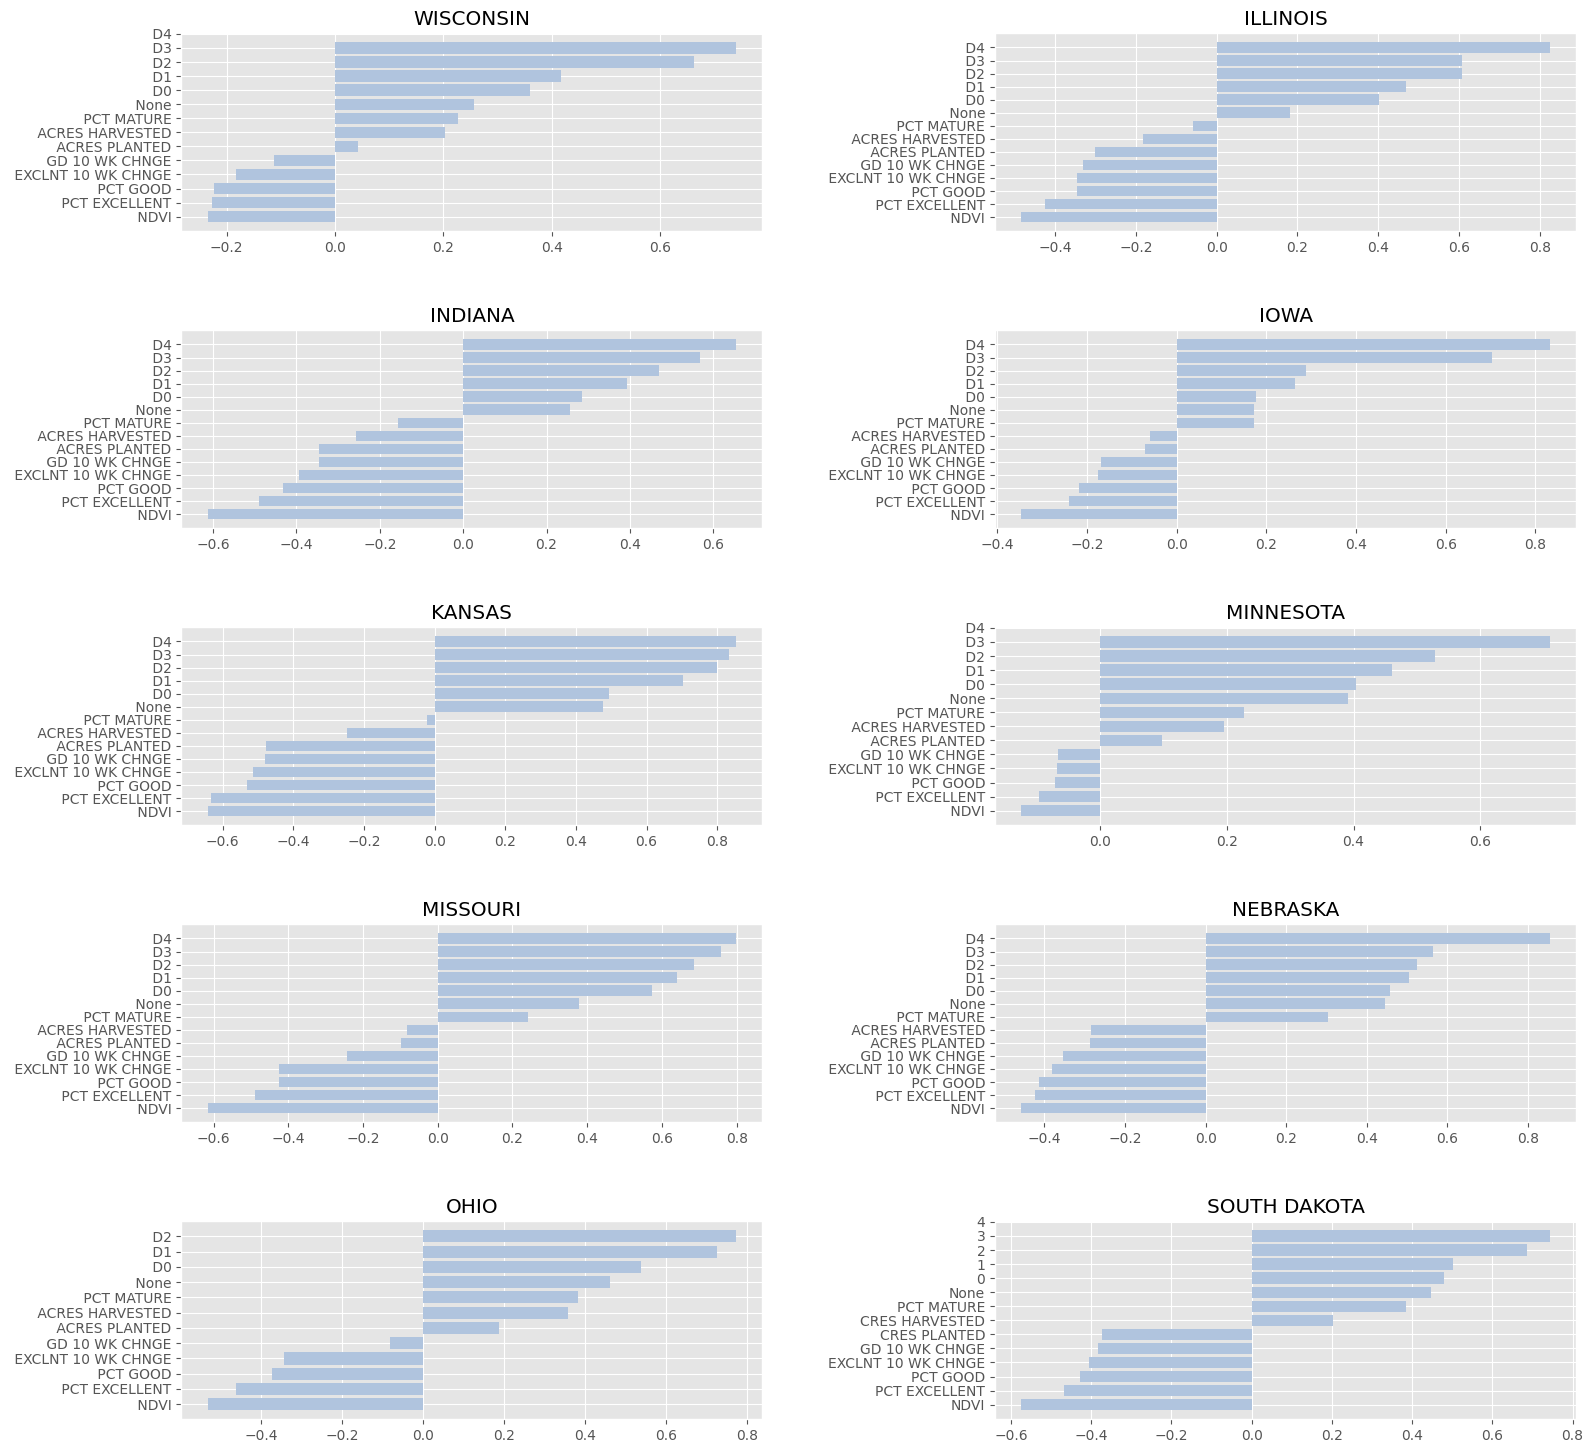

In [153]:
fig, axs = plt.subplots(5, 2, figsize=(18, 18))

for i, ax in enumerate(fig.axes):
    state = y.columns[i-1]
    corr = x.filter(regex=state).apply(lambda x: spearmanr(x, y[state])[0])
    ax.barh(y=corr.index.str.lstrip(state), width=corr.sort_values(), color='lightsteelblue')
    ax.set_title(state);

plt.subplots_adjust(hspace=0.5, wspace=0.4)

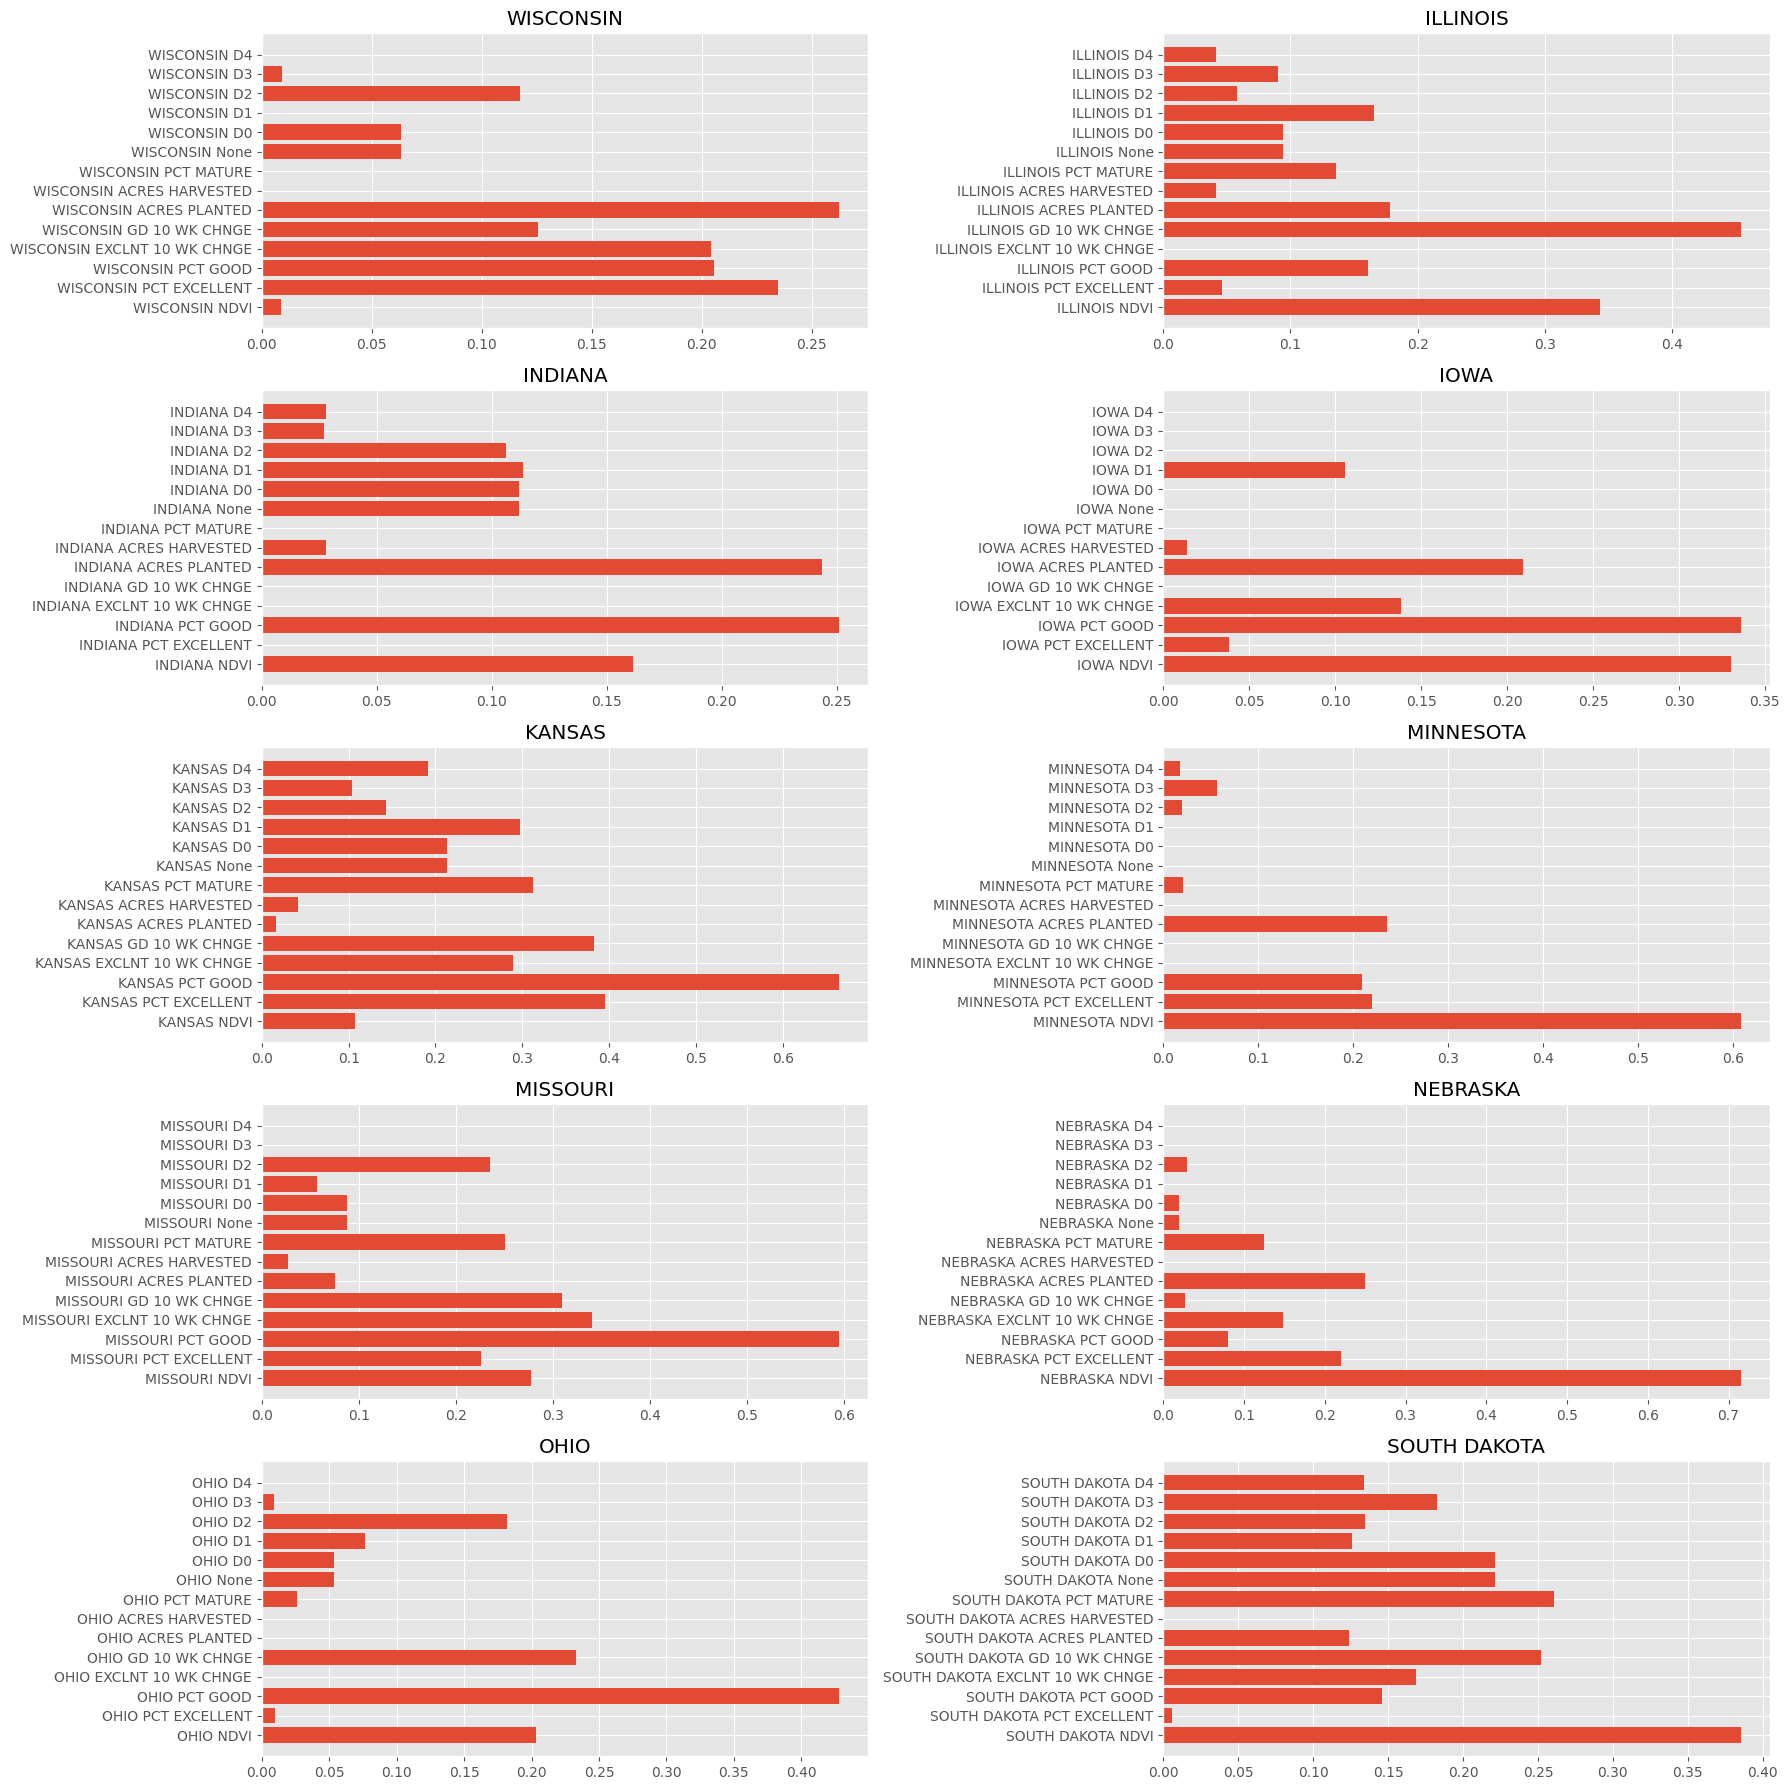

,SOUTH DAKOTA NDVI,OHIO NDVI,NEBRASKA NDVI,MISSOURI NDVI,MINNESOTA NDVI,IOWA NDVI,INDIANA NDVI,ILLINOIS NDVI,IOWA PCT EXCELLENT,KANSAS PCT EXCELLENT,...,MINNESOTA D3,KANSAS D0,KANSAS D1,IOWA D1,INDIANA None,INDIANA D0,INDIANA D1,INDIANA D2,ILLINOIS D0,ILLINOIS D1
0,0.340499,0.621601,0.029884,0.879042,0.442379,0.285127,0.375975,0.438817,0.814815,0.363636,...,0.000000,0.497384,0.342984,0.902734,0.328654,0.671346,0.829290,0.776953,0.753297,0.833463
1,0.074472,0.055121,0.376607,0.818707,0.324482,0.308956,0.000000,0.000000,0.296296,0.363636,...,0.000000,0.117368,0.056616,0.056384,0.712404,0.287596,0.203287,0.087303,0.277311,0.102602
2,0.249520,0.000000,0.000000,0.545901,0.832714,0.626130,0.123245,0.185908,0.703704,0.045455,...,0.000000,0.720664,0.634377,0.090174,0.479814,0.520186,0.347411,0.101279,0.331980,0.160884
3,0.025720,0.548603,0.461761,0.693129,0.000000,0.000000,0.185647,0.218308,0.222222,0.045455,...,0.149185,0.787382,0.684627,0.863341,0.699630,0.300370,0.296681,0.220742,0.607668,0.519172
4,0.616507,0.812663,0.388496,0.932448,0.828996,0.672966,0.742070,0.706197,0.814815,1.000000,...,0.049481,0.421821,0.360967,0.076284,0.888144,0.111856,0.026463,0.000000,0.102487,0.000008


In [154]:
# Filtering based on mutual information for each variable

fig, axs = plt.subplots(5, 2, figsize=(18, 18))

for i, ax in enumerate(fig.axes):
    state = y.columns[i-1]
    state_data = x.filter(regex=state)
    mi = mutual_info_regression(X=state_data,
                                y=y[state],
                                random_state=42
                                )
    mutual_info = pd.DataFrame(mi, index=state_data.columns, columns=[state])
    x.drop(columns=mutual_info[state].nsmallest(math.floor(len(mutual_info.index) / 2)).index, inplace=True)
    ax.barh(state_data.columns, mutual_info[state])
    ax.set_title(state)
plt.tight_layout()
plt.show()

x.head()

In [155]:

# Returns feature coefficients of regression model
def feature_importance(model, df, ax, num_features, plot=False, print_results=False):
        importance = model.coef_
        keys = list(df.keys())
        abs_weights = {}
        weights = {}
        for i,v in enumerate(importance):
            if print_results:
                print("Feature: %s, Score: %.5f" % (keys[i],v))
            abs_weights[keys[i]] = abs(v)
            weights[keys[i]] = v
        if plot:
            ax.bar([x for x in range(len(importance))], height=importance, color='b')
            tickvals = range(0, len(importance))
            cols = df.columns
            ax.set_xticks(ticks=tickvals, labels=cols, rotation=45, fontsize='xx-small', fontstretch='extra-condensed')
        
        largest_features = heapq.nlargest(num_features, abs_weights, key=abs_weights.get)

        avg_abs_weight = sum([abs_weights.get(key) for key in largest_features]) / len(largest_features)
        return largest_features, weights, avg_abs_weight

In [156]:

# Returns optimized model based on RandomSearchCV and specified parameters.

def get_best_model(X, y, kwargs=None, lasso=True):
    xgb_params = {
    "learning_rate": np.arange(0.01, 0.2, 0.01),
    "min_child_weight": np.arange(1, 5, 1),
    "n_estimators": range(800, 1200),
    "max_depth": range(1, 5),
    "colsample_bytree": np.arange(0.1, 1, 0.1),
    "subsample": np.arange(0.1, 1, 0.1)
    }

    lasso_params = {
        "alpha": np.arange(0.05, 2, 0.05)
    }

    if not lasso:
        optimized_model = RandomizedSearchCV(param_distributions=xgb_params, estimator=xgb.XGBRegressor(**kwargs), scoring='neg_mean_absolute_error', verbose=1, random_state=42, cv=2)
        optimized_model.fit(X, y)
        print("Best Parameters:", optimized_model.best_params_)
    else: 
        optimized_model = RandomizedSearchCV(param_distributions=lasso_params, estimator=Lasso(random_state=42), scoring='neg_mean_absolute_error', verbose=1, random_state=42)
        optimized_model.fit(X, y)
        print("Best Parameters:", optimized_model.best_params_)
    return optimized_model

In [157]:
# Fitting models, analyzing and plotting data

def reg_plot(x, y, title, ax=None):
    X_train = x.iloc[0:15]
    X_test = x.iloc[15:20]
    X_cv = x.iloc[20:]
    y_train = y.iloc[0:15]
    y_test = y.iloc[15:20]
    y_cv = y.iloc[20:]


    # For most crops, a lower alpha (<= 0.7) is best. Higher alphas run the risk of reducing all coefficients to 0
    model = Lasso(alpha=0.45, random_state=42)
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    weighted_features, weights, avg_abs_weight = feature_importance(model, X_train, ax, math.ceil(X_train.shape[1]/2))

    residuals = y_train - y_train_pred[0]
    residuals = pd.DataFrame(residuals, index=y_train.index)

    monotone_csts = np.zeros(len(weighted_features))
    monotone_csts = np.array(monotone_csts, dtype=int)
    for i in range(len(weighted_features)):

        if weights[weighted_features[i]] < 0 and abs(weights[weighted_features[i]]) > avg_abs_weight:
            monotone_csts[i] = -1
        elif weights[weighted_features[i]] > 0 and weights[weighted_features[i]] > avg_abs_weight:
            monotone_csts[i] = 1

    kwargs = {
        "monotone_constraints": f"{tuple(monotone_csts)}"
    }

    resid_model = xgb.XGBRegressor(
                                   max_depth=4,
                                   colsample_bytree=0.5,
                                   min_child_weight=2,
                                   **kwargs)
    resid_model.fit(X_train.loc[:, weighted_features], residuals)

    ax.scatter(y_train.index, y_train)
    ax.plot(y_train.index, y_train_pred)
    pred2 = resid_model.predict(X_test.loc[:, weighted_features]) + y_test_pred
    pred2 = pd.DataFrame(pred2, index=y_test.index)
    ax.scatter(y_test.index, y_test)
    ax.plot(y_test.index, pred2)
    
    resid_cv = y_test - y_test_pred
    resid_cv = pd.DataFrame(resid_cv, index=y_test.index)

    resid_cv_model = xgb.XGBRegressor(
                                   max_depth=4,
                                   colsample_bytree=0.5,
                                   min_child_weight=2,
                                   **kwargs)
    resid_cv_model.fit(X_test.loc[:, weighted_features], resid_cv)
    resid_cv_pred = resid_cv_model.predict(X_cv.loc[:, weighted_features])
    pred3 = model.predict(X_cv)

    pred3 = resid_cv_pred + pred3
    pred3 = pd.DataFrame(pred3, index=y_cv.index)
    ax.scatter(y_cv.index, y_cv)
    ax.plot(y_cv.index, pred3)

    ax.set_title(title)

    s = mean_absolute_error(y_cv, pred3)
    at = AnchoredText(
        f"{s:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)

    return ax 

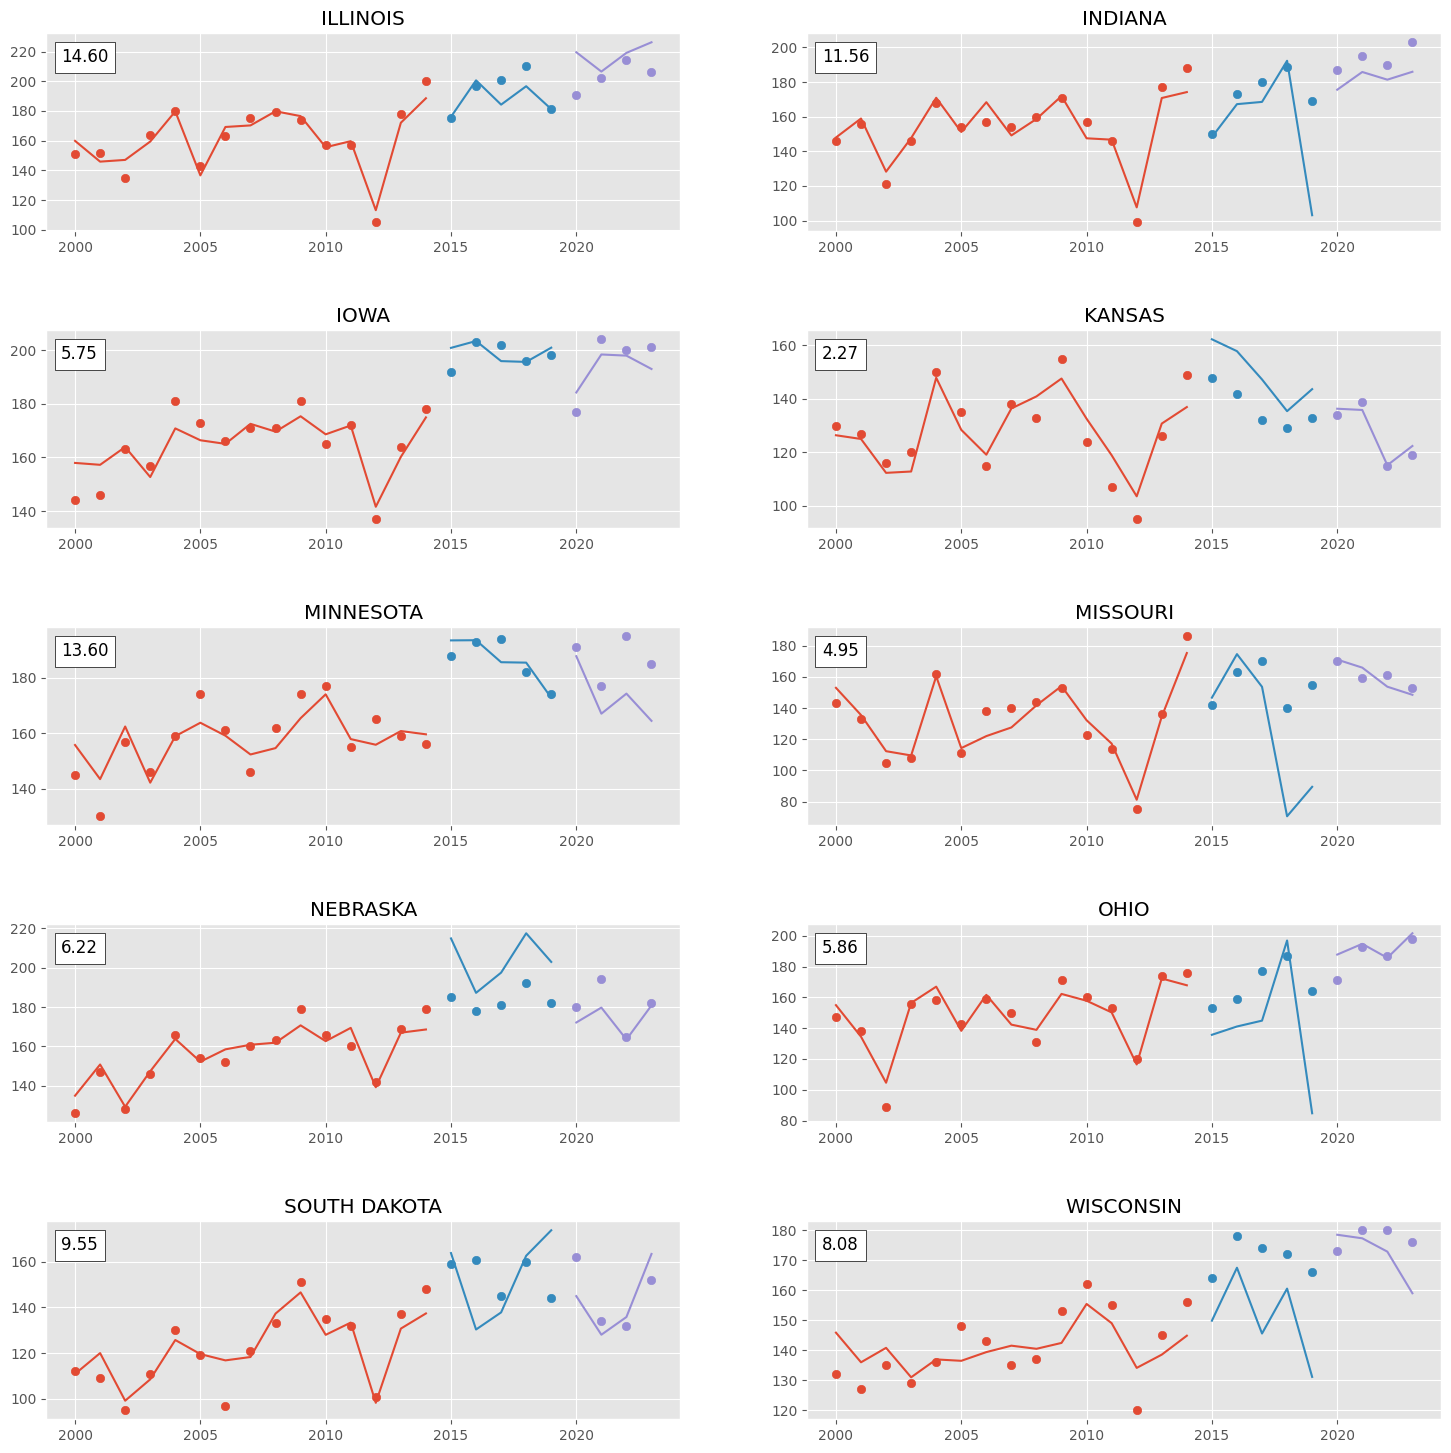

In [158]:

fig, axs = plt.subplots(5, 2, figsize=(18, 18))

for i, ax in enumerate(fig.axes):
    col_name = y.columns[i]
    state_data = x.filter(regex=col_name)
    input = state_data
    if "D1" in x.columns:
        drought_data = x.loc[:, ["D1", "D2", "D3", "D4"]]
        input = pd.concat([input, drought_data], axis=1, ignore_index=False)

    reg_plot(input, y.iloc[:, i], col_name, ax)

plt.subplots_adjust(hspace=0.5)
plt.show()